In [1]:
using SciBmad
include("../lattices/RCSV5S0_lattice.jl");
t = twiss(ring)

Table with 28 columns and 5389 rows:
      s       phi_1       beta_1   alpha_1      phi_2      beta_2    ⋯
    ┌─────────────────────────────────────────────────────────────────
 1  │ 0.0     0.0         14.5816  2.04834e-15  0.0        0.86833   ⋯
 2  │ 0.235   0.00258391  14.264   1.34136      0.0417706  0.951822  ⋯
 3  │ 0.29    0.00320077  14.117   1.33057      0.0507712  0.994778  ⋯
 4  │ 0.31    0.00342668  14.0639  1.32665      0.0539436  1.01218   ⋯
 5  │ 0.348   0.00385825  13.9633  1.31919      0.0598175  1.04784   ⋯
 6  │ 0.605   0.00686009  13.2982  1.26875      0.0941101  1.37893   ⋯
 7  │ 0.643   0.00731653  13.2021  1.2613       0.0984008  1.44117   ⋯
 8  │ 6.51    0.133202    5.1572   0.109917     0.216762   52.1116   ⋯
 9  │ 6.565   0.134901    5.1457   0.0991232    0.216928   52.9726   ⋯
 10 │ 7.035   0.148986    5.71223  -1.35087     0.218299   54.1275   ⋯
 11 │ 7.09    0.150499    5.86232  -1.37807     0.218461   53.5243   ⋯
 12 │ 7.11    0.151039    5.91764  -1.38

In [2]:
# Could get tunes from twiss via
t.phi_1[end], t.phi_2[end]

(43.130001699797795, 56.210001125713354)

In [3]:
# Alternatively use the normal form library directly (useful if you want amplitude-dependent tune)
const D3 = Descriptor(6, 3); # 6 variables, 3rd order
b0 = Bunch(zeros(6) + vars(D3)); # Identity map as Bunch
track!(b0, ring);
m = DAMap(v=b0.coords.v)
a = normal(m)
c = c_map(m) # Transform to phasor basis
r = inv(c) ∘ inv(a) ∘ m ∘ a ∘ c

# Need to cut highest order
Q_x = cutord(real(-log(SciBmad.NNF.factor_out(r.v[1], 1))/(2*pi*im)), 3)
Q_y = cutord(real(-log(SciBmad.NNF.factor_out(r.v[3], 3))/(2*pi*im)), 3)
GTPSA.show_eps = 1e-5 # hide tiny monomials
Q_x, Q_y # Note: 1 1 0 0 0 0 refers to J_x, 0 0 1 1 0 0 refers to J_y, and 0 0 0 0 1 1 refers to J_z

Setting bunch.species = Species(electron, charge=-1.0e, mass=510998.95069 eV/c², spin=0.5ħ) (reference species from the Beamline)
Setting bunch.R_ref = -2.501730133317857 (reference R_ref from the Beamline)


(TPS64{GTPSA.Dynamic}:
Descriptor(NV=6, MO=3)
 Coefficient                Order   Exponent
  1.3000169979782961e-01      0      0   0   0   0   0   0
  3.7076710151156108e+03      2      1   1   0   0   0   0
  4.8023715457165134e+04      2      0   0   1   1   0   0
  4.5194049096696185e+00      2      0   0   0   0   1   1
, TPS64{GTPSA.Dynamic}:
Descriptor(NV=6, MO=3)
 Coefficient                Order   Exponent
  2.1000112571337831e-01      0      0   0   0   0   0   0
  4.8023715457166087e+04      2      1   1   0   0   0   0
  2.2306646073725708e+04      2      0   0   1   1   0   0
  8.3766373065047404e+00      2      0   0   0   0   1   1
)

So here we have $\frac{\partial Q_x}{\partial J_x} =  3.7076710151156108\times 10^3$ for example.

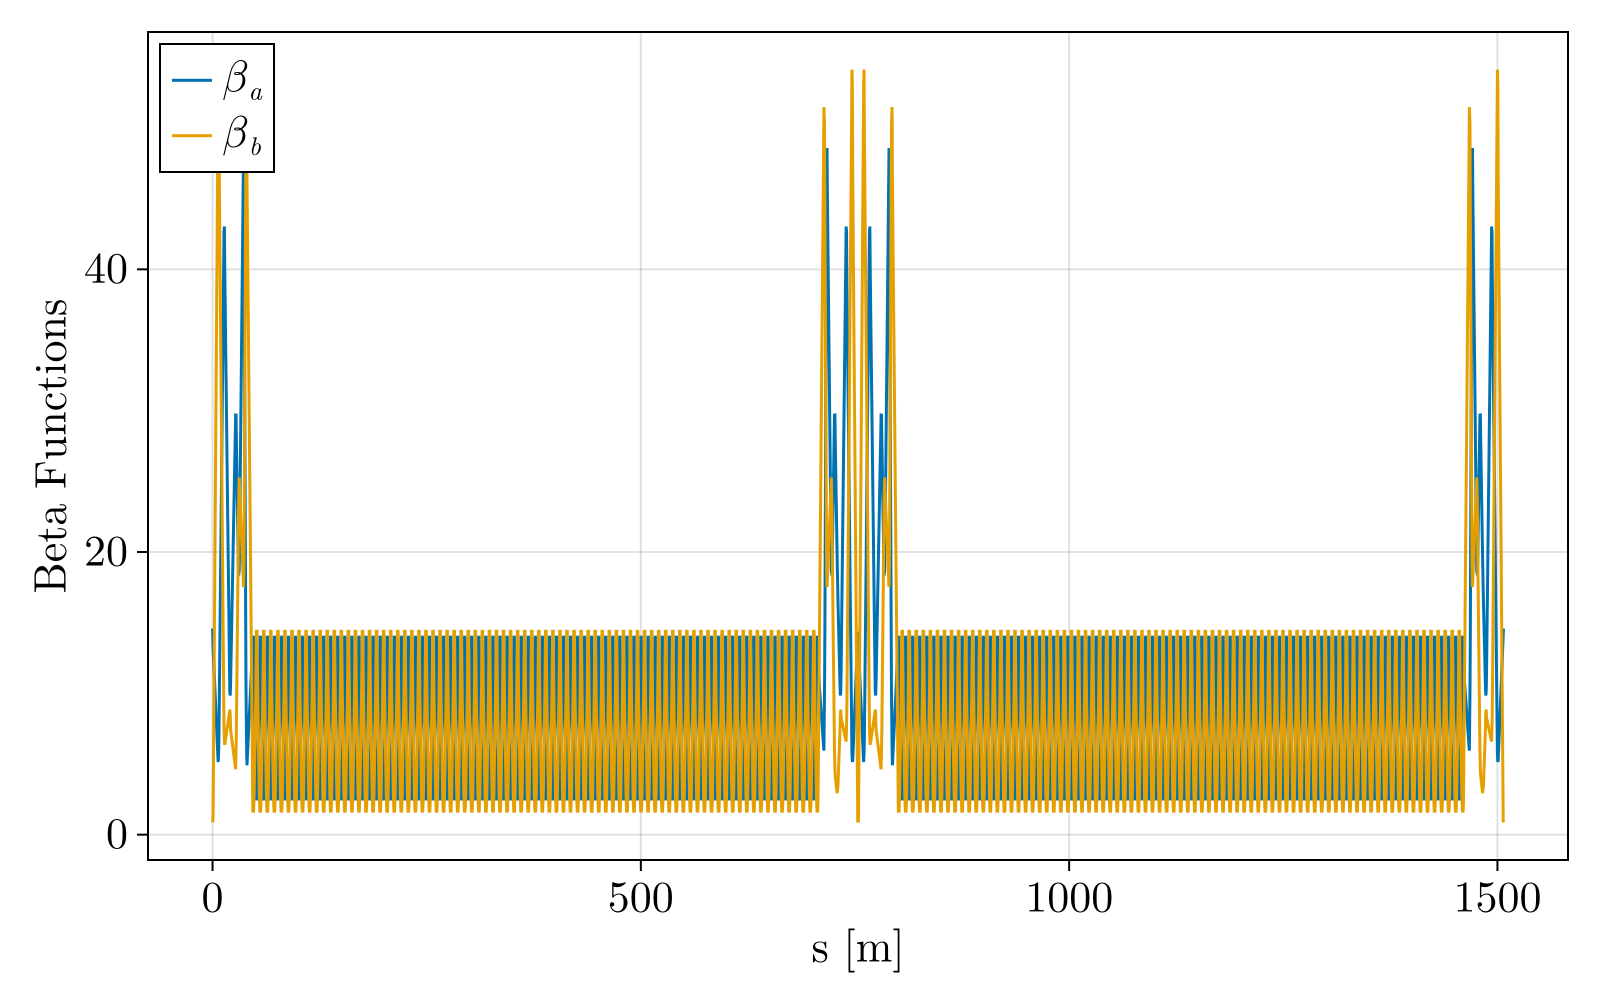

In [4]:
# Plot the betas
using CairoMakie
with_theme(theme_latexfonts()) do
    f = Figure(fontsize=22, size=(800,500));
    ax = Axis(f[1, 1], xlabel="s [m]", ylabel="Beta Functions");
    lines!(ax, t.s, t.beta_1, label=L"\beta_a"); # L".." specifies a LaTeX string
    lines!(ax, t.s, t.beta_2, label=L"\beta_b");
    axislegend(position=:lt);
    display(f);
end;

In [5]:
# Let's see the linear closed orbit response as a function of
# e.g. qf_1 y_alignment and b0_1 tilt (2 PARAMETERS)
const DPARAMS1 = Descriptor(6, 1, 2, 1) # 6 dynamic variables to 1st order, 2 parameters to 1st order
Δk = params(DPARAMS1)
qf_1.y_offset = Δk[1] # make y_offset a parameter
b0_1.tilt = Δk[2]      # make tilt a parameter
t = twiss(ring; GTPSA_descriptor=DPARAMS1);

In [6]:
# Closed orbit is now a Taylor series in the parameters:
# E.g. at the first element:
t.orbit_y[1]

TPS64{GTPSA.Dynamic}:
Descriptor(NV=6, MO=1, NP=2, PO=1)
 Coefficient                Order   Exponent
 -2.7843532447442293e-01      1      0   0   0   0   0   0   |   1   0
 -3.5426682007214952e-02      1      0   0   0   0   0   0   |   0   1


This says that $\frac{\partial y_{co}}{\partial(\textrm{y\_offset})} = -2.7843532447442293\times 10^{-1}$ and $\frac{\partial y_{co}}{\partial(\textrm{tilt})} = -3.5426682007214952\times 10^{-2}$.
See the orbit response around the ring:

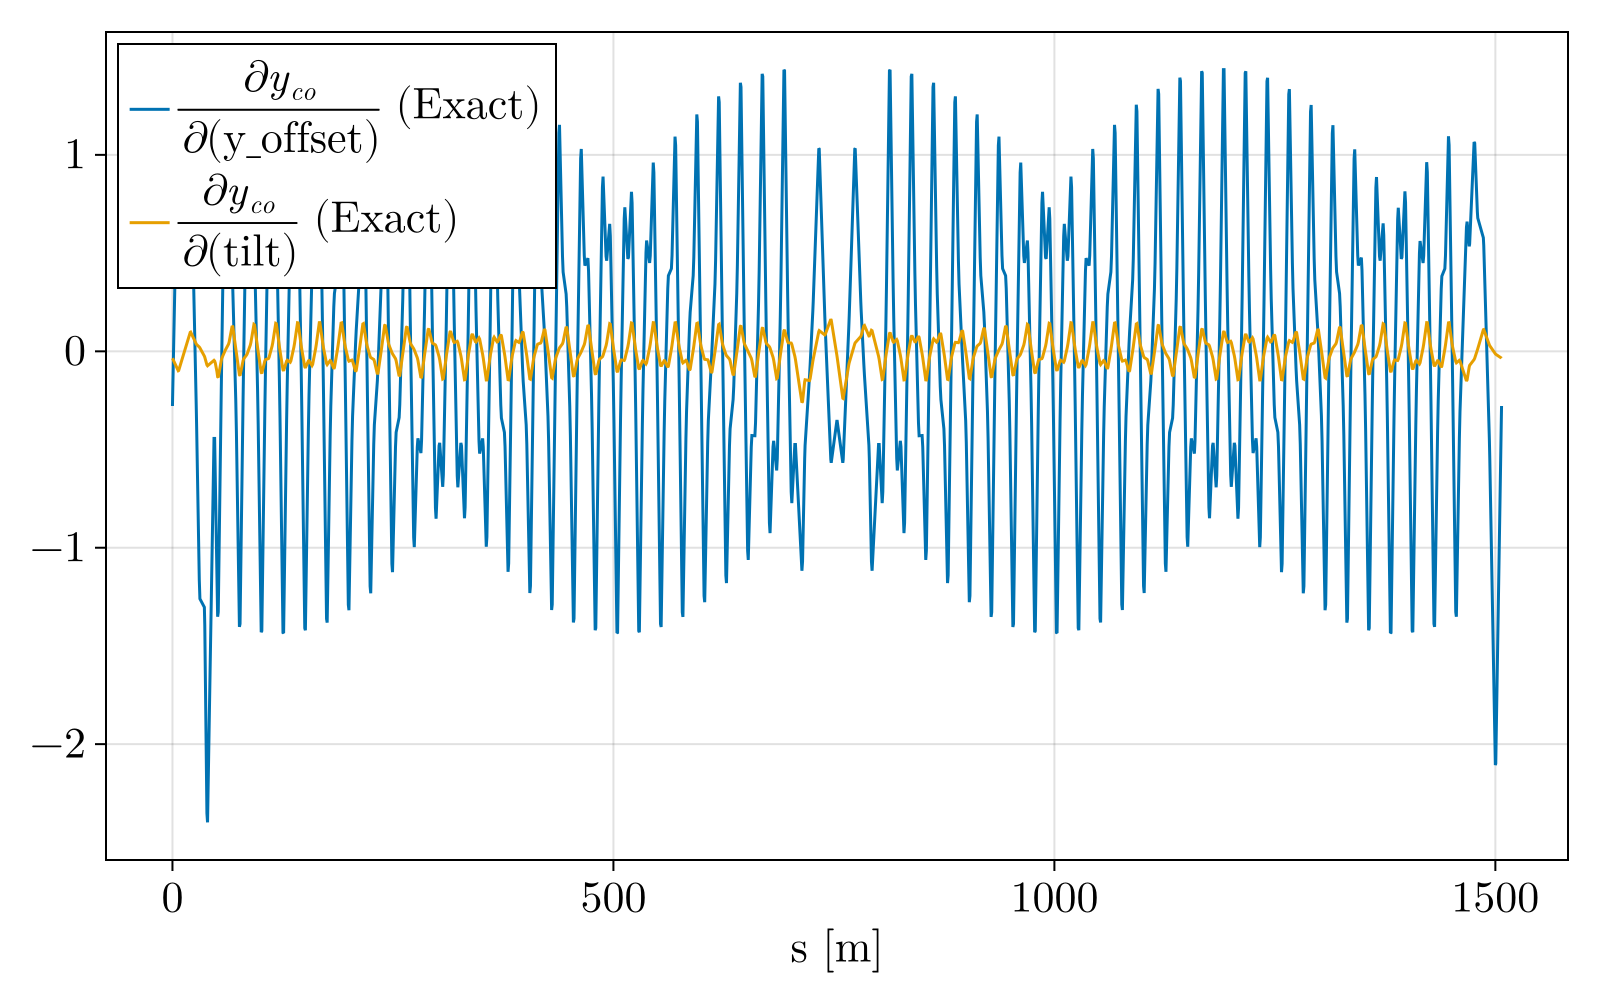

In [6]:
dy_dy_offset = map(x->x[[0,0,0,0,0,0,1]], t.orbit_y)
dy_dtilt = map(x->x[[0,0,0,0,0,0,0,1]], t.orbit_y)

# Plot the response around the ring:
with_theme(theme_latexfonts()) do
    f = Figure(fontsize=22, size=(800,500));
    ax = Axis(f[1, 1], xlabel="s [m]");
    lines!(ax, t.s, dy_dy_offset, label=L"\frac{\partial y_{co}}{\partial(\textrm{y\_offset})}\ \textrm{(Exact)}"); # L".." specifies a LaTeX string
    lines!(ax, t.s, dy_dtilt, label=L"\frac{\partial y_{co}}{\partial(\textrm{tilt})}\ \textrm{(Exact)}");
    axislegend(position=:lt);
    display(f);
end;

Now let's compare to finite differencing:

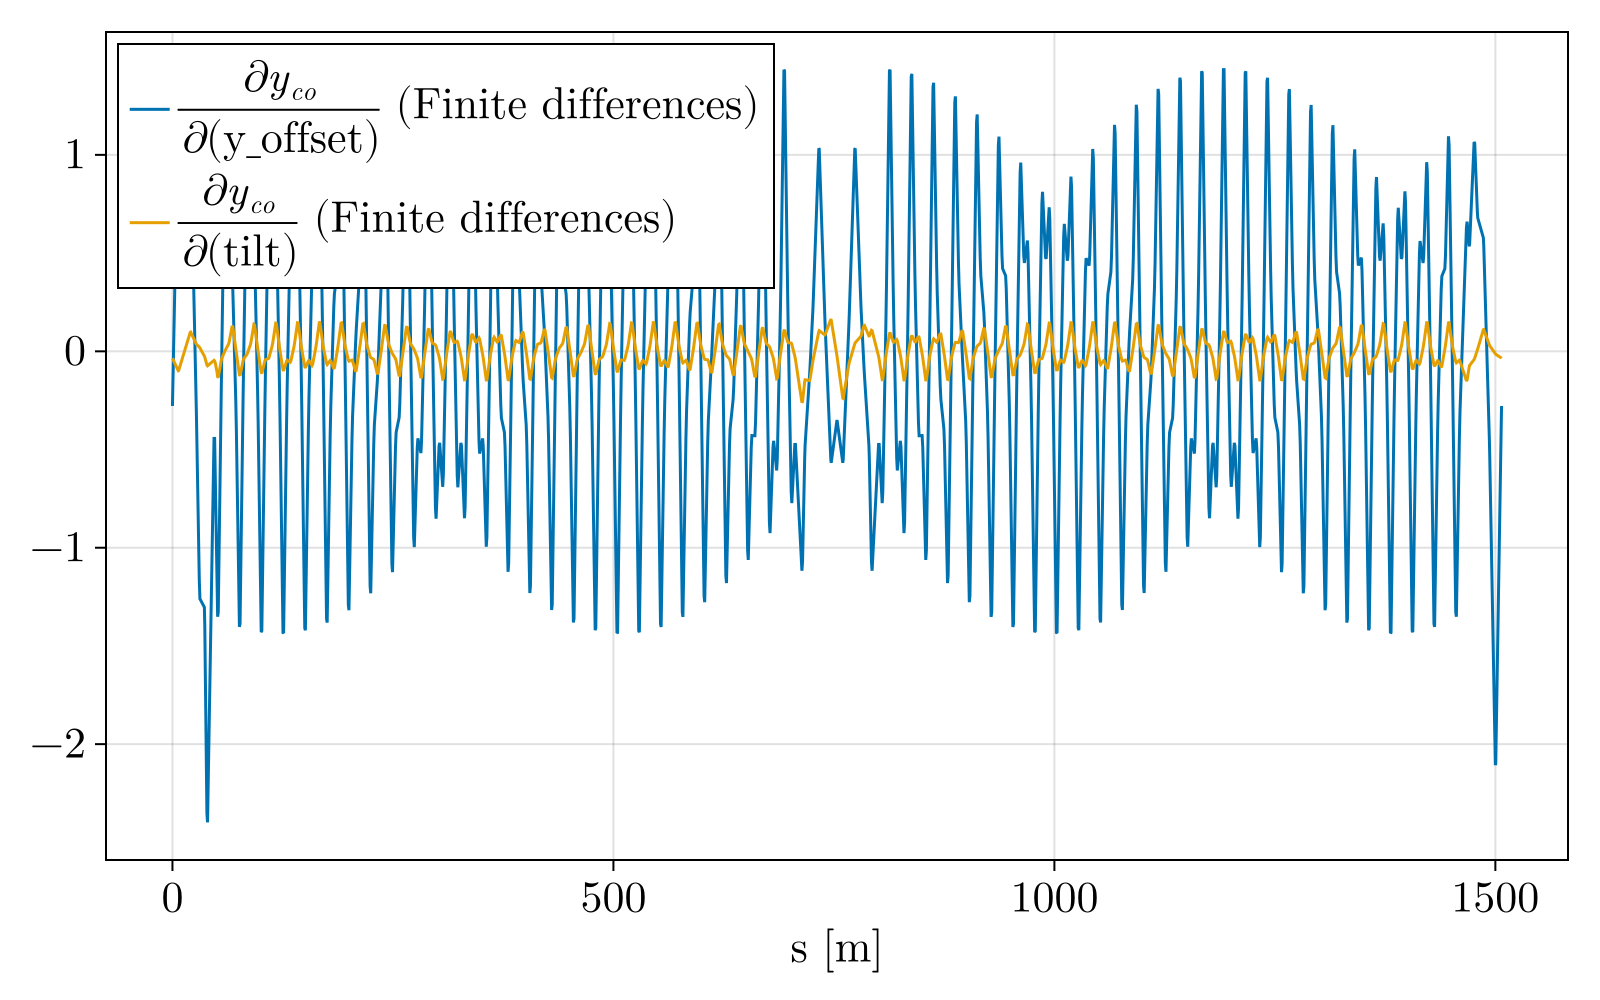

In [7]:
step = 1e-6

# First dy/dy_offset
qf_1.y_offset = step
b0_1.tilt = 0
t = twiss(ring)
# scalar gets zeroth order part
dy_dy_offset_FD = scalar.(t.orbit_y)/step

# Now dy/dtilt:
qf_1.y_offset = 0
b0_1.tilt = step
t = twiss(ring)
dy_dtilt_FD = scalar.(t.orbit_y)/step

# And plot:
# Plot the response around the ring:
with_theme(theme_latexfonts()) do
    f = Figure(fontsize=22, size=(800,500));
    ax = Axis(f[1, 1], xlabel="s [m]");
    lines!(ax, t.s, dy_dy_offset_FD, label=L"\frac{\partial y_{co}}{\partial(\textrm{y\_offset})}\ \textrm{(Finite differences)}"); # L".." specifies a LaTeX string
    lines!(ax, t.s, dy_dtilt_FD, label=L"\frac{\partial y_{co}}{\partial(\textrm{tilt})}\ \textrm{(Finite differences)}");
    axislegend(position=:lt);
    display(f);
end;

Finite differences is usually ok for first order derivatives, but suffers significant error beyond that. Thanks to SciBmad's automatic differentiability, we can exactly compute the nonlinear derivatives. Simply specify a higher order for the GTPSA `Descriptor` and follow the same procedure above.